In [1]:
%matplotlib widget
import os, sys
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

In [2]:
sys.path.append(os.path.dirname(os.getcwd()))
from utils.nb import isnotebook
from utils.viz.viz import plot_fustrum, plot_crs, set_3d_axes_equal

In [3]:
# image/camera parameters
pixel_size = 1.88e-6 # [mm]
width = 4000
height = 3000
focal_length = 2873.58 

# view parameters, a.k.a. extrinsics
X0 = np.array([ -9.43042754, -88.12031844, 3.71859811])
#pry = np.array([0.79256661, -0.03314911, -2.99098413])
#R_w_c = Rotation.from_euler('XYZ', pry, degrees=False).as_matrix()
R_w_c = Rotation.from_euler('XYZ', [20, 0, -180], degrees=True).as_matrix()
R_c_w = R_w_c.transpose()

In [4]:
R2 =  [[-0.9881368 ,  0.14995736, -0.03314304],
       [-0.08199503, -0.6976143 , -0.71176618],
       [-0.12985564, -0.70060479,  0.70163412]]

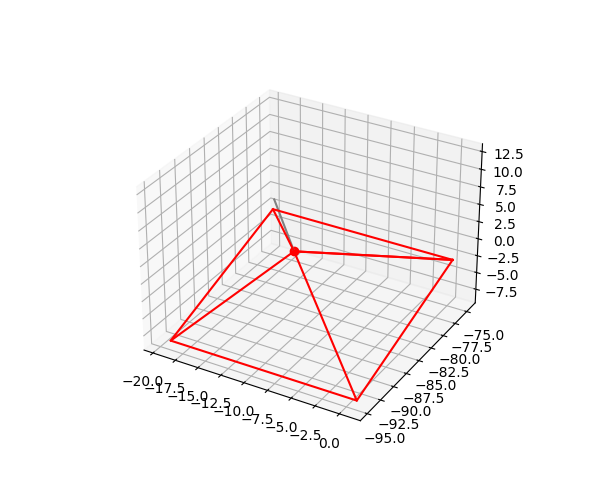

In [5]:
plt.figure(figsize=(6,5))
ax = plt.axes(projection='3d')
plot_fustrum(ax, X0, R_c_w, f=-1.0, scale=10)
set_3d_axes_equal(ax)

In [6]:
fustrum_c = np.array([[-width, -height, -focal_length], [-width, height, -focal_length], 
                   [width, height, -focal_length], [width, -height, -focal_length], 
                   [-width, -height, -focal_length]])

In [7]:
fustrum_w = focal_length*pixel_size/1000 * (R_c_w @ fustrum_c.T ).T + X0

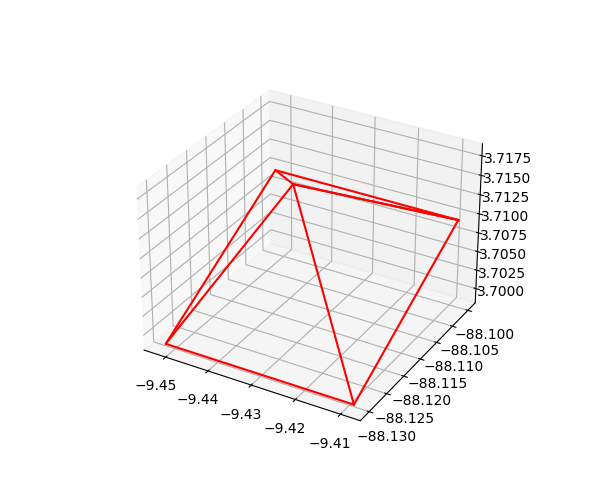

In [8]:
plt.figure(figsize=(6,5))
ax = plt.axes(projection='3d')
ax.plot3D(fustrum_w[:,0], fustrum_w[:,1], fustrum_w[:,2], c='r')
for pt in fustrum_w:
        ax.plot3D([X0[0], pt[0]], [X0[1], pt[1]], [X0[2], pt[2]], c='r')

In [9]:
def plane_line_intersection(p0, pn, l0, l1, epsilon=1e-6):
    l = l1 - l0
    l = l / np.linalg.norm(l)
    denom = l.dot(pn)
    if np.abs(denom) < epsilon:
        return None
    d = (p0-l0).dot(pn) / denom
    return l0 + d*l   

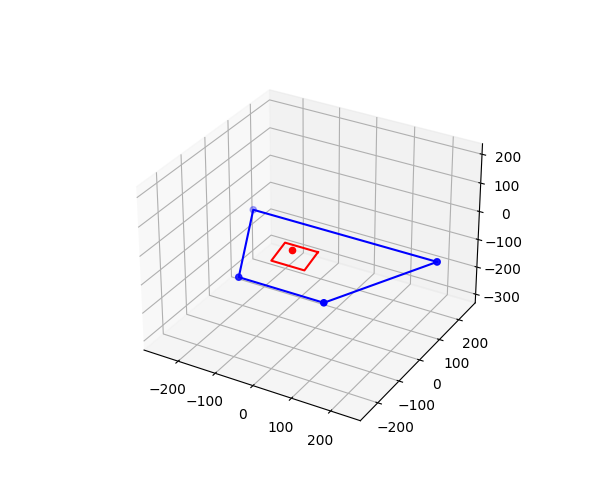

In [10]:
plt.figure(figsize=(6,5))
ax = plt.axes(projection='3d')
scale = 2000
fustrum_w_scaled = ((fustrum_w - X0) * scale) + X0
ax.plot3D(fustrum_w_scaled[:,0], fustrum_w_scaled[:,1], fustrum_w_scaled[:,2], c='r')

footprint = []
ax.scatter3D(X0[0], X0[1], X0[2], c='r')
for pt in fustrum_w:
        ax.plot3D([X0[0], pt[0]], [X0[1], pt[1]], [X0[2], pt[2]], c='r')
        p0 = np.array([0, 0, -100])
        pn = np.array([0, 0, 1])
        l0 = X0
        ground_pt = plane_line_intersection(p0, pn, l0, pt)
        footprint.append(ground_pt)
        
footprint = np.array(footprint)
ax.scatter3D(footprint[:, 0], footprint[:, 1], footprint[:, 2], c='b')
ax.plot3D(footprint[:, 0], footprint[:, 1], footprint[:, 2], c='b')
set_3d_axes_equal(ax)

In [16]:
def get_image_footprint(width, height, focal_length_pix, pixel_size, X0, R_w_c, ground_level):

    fustrum_c = np.array([[-width, -height, -focal_length_pix], [-width, height, -focal_length_pix],
                   [width, height, -focal_length_pix], [width, -height, -focal_length_pix],
                   [-width, -height, -focal_length_pix]])

    fustrum = focal_length_pix*pixel_size * (R_w_c @ fustrum_c.T ).T + X0

    p0 = np.array([0, 0, ground_level])
    pn = np.array([0, 0, 1])
    #l0 = np.array([0, 0, 0])

    footprint = []
    for pt in fustrum:
        ground_pt = plane_line_intersection(p0, pn, X0, pt)
        footprint.append(ground_pt)

    footprint = np.array(footprint)
    return footprint


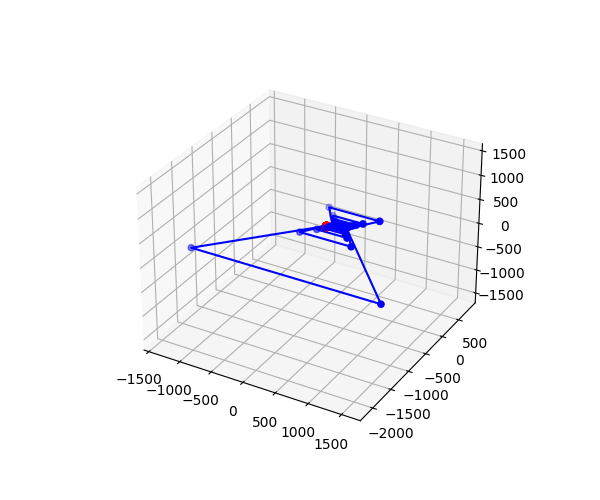

In [17]:
plt.figure(figsize=(6,5))
ax = plt.axes(projection='3d')

for pitch in range(-40, 40, 10):
    R_w_c = Rotation.from_euler('XYZ', [pitch, 0, -180], degrees=True).as_matrix()
    X0_i = np.array([100, 100, 0])
    footprint = get_camera_footprint(width, height, focal_length, pixel_size/1000, X0_i, R_w_c.transpose(), -100)


    plot_fustrum(ax, X0, R_w_c, f=-1.0, scale=30)
    ax.scatter3D(footprint[:, 0], footprint[:, 1], footprint[:, 2], c='b')
    ax.plot3D(footprint[:, 0], footprint[:, 1], footprint[:, 2], c='b')

    set_3d_axes_equal(ax)